In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pingouin

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [78]:
data_et_fixCal_raw = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et_fixCal.csv')
data_trial_fixCal_raw = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial_fixCal.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et_fixCal_raw)],
        [len(data_trial_fixCal_raw)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et_fixCal_raw', 
        'data_trial_fixCal_raw', 
        'data_subject'
          ]
)
print(overview)

                       length
data_et_raw            618566
data_et_fixCal_raw     462562
data_trial_fixCal_raw   11234
data_subject               62


# Create datasets

In [79]:
data_trial_calibration_raw = data_trial_fixCal_raw.loc[
    data_trial_fixCal_raw['trial_type']=='eyetracking-calibration', :]

data_et_calibration_raw = data_et_fixCal_raw.loc[
    data_et_fixCal_raw['trial_type']=='eyetracking-calibration', :]

data_trial_fix_raw = data_trial_fixCal_raw.loc[
    (data_trial_fixCal_raw['trial_type']=='eyetracking-fix-object') & 
    (data_trial_fixCal_raw['trial_duration']==5000), 
    :]

temp = data_et_fixCal_raw.merge(
    data_trial_fixCal_raw.loc[:, ['run_id', 'trial_index', 'trial_duration']],
    on=['run_id', 'trial_index'],
    how='left'
)
data_et_fix_raw = temp.loc[
    (temp['trial_type']=='eyetracking-fix-object') &
    (temp['trial_duration']==5000), 
    :
]

# Cleaning

## Enough trials?

In [60]:
NTrials = data_trial_fixCal_raw.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_not_enough_trials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
55    2002         99.0
57    2009        255.0
58    2011         32.0


## Followed instructions? 

In [61]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin
3,12,5b8969006651ea000118e42e,1.0,0.0
25,48,5fa1192cf99e161a5cfad1cd,1.0,0.0
42,9,5fea6632bf9ae4a79153efdf,1.0,0.0
54,1003,0,1.0,0.0
55,1008,Ka61Kl61,1.0,0.0
59,2002,Tim,0.0,0.0
60,2008,Studie1970,0.0,1.0


## filter

In [62]:
cleanSubjects = data_subject.loc[
        (data_subject['status']=='APPROVED') &
        (data_subject['keptHead']!=0) &
        (data_subject['triedChin']!=0) &
        pd.notna(data_subject['fps']) &
        ~(data_subject['run_id'].isin(subjects_not_enough_trials)), 
        'run_id'
    ].unique()
cleanSubjects

array([103,  11, 126, 128,  13, 130, 131,  19,  24,  25,  28,  30,  32,
        36,  37,   4,  41,  42,  43,  45,  47,   5,  58,  59,   6,  63,
        66,  67,   7,  70,  74,  80,  81,  85,  91,  92,  93,  94,  96,
        97], dtype=int64)

### trial data

In [63]:
data_trial_fixCal = data_trial_fixCal_raw.loc[
    data_trial_fixCal_raw['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial_fixCal')
print('raw: ' + str(len(data_trial_fixCal_raw)))
print('cleaned: ' + str(len(data_trial_fixCal)))

data_trial_fixCal
raw: 11234
cleaned: 7710


In [65]:
data_trial_calibration = data_trial_calibration_raw.loc[
    data_trial_calibration_raw['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial_calibration')
print('raw: ' + str(len(data_trial_calibration_raw)))
print('cleaned: ' + str(len(data_trial_calibration)))

data_trial_calibration
raw: 4545
cleaned: 3088


In [66]:
data_trial_fix = data_trial_fix_raw.loc[
    data_trial_fix_raw['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial_fix')
print('raw: ' + str(len(data_trial_fix_raw)))
print('cleaned: ' + str(len(data_trial_fix)))

data_trial_fix
raw: 1044
cleaned: 711


### et data

In [64]:
def cleanETData(data, cleanSubjects):
    return data.loc[
        (data['x']>0) & (data['x']<1) &(data['y']>0) & (data['y']<1) &
        (data['run_id'].isin(cleanSubjects)), :] \
        .reset_index(drop=True)

data_et_fixCal = cleanETData(data_et_fixCal_raw, cleanSubjects)

print('data_et_fixCal')
print('raw: ' + str(len(data_et_fixCal_raw)))
print('cleaned: ' + str(len(data_et_fixCal)))

data_et_fixCal
raw: 462562
cleaned: 353046


In [67]:
data_et_calibration = cleanETData(data_et_calibration_raw, cleanSubjects)

print('data_et_calibration')
print('raw: ' + str(len(data_et_calibration_raw)))
print('cleaned: ' + str(len(data_et_calibration)))

data_et_calibration
raw: 277038
cleaned: 208384


In [68]:
data_et_fix = cleanETData(data_et_fix_raw, cleanSubjects)
data_et_fix = data_et_fix.loc[
    (data_et_fix['t_task']>1000) &
    (data_et_fix['t_task']<5001)
] \
    .reset_index(drop=True)
print('data_et_fix')
print('raw: ' + str(len(data_et_fix_raw)))
print('cleaned: ' + str(len(data_et_fix)))

data_et_fix
raw: 81877
cleaned: 50976


In [69]:
print('data_subject raw: ' + str(len(data_subject)))
data_subject = data_subject.loc[data_subject['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)
print('data_subject cleaned: ' + str(len(data_subject)))
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

data_subject raw: 62
data_subject cleaned: 40


# Add variables

## Offset

### Calculate on gaze point-level

In [70]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

def offset(data):
    offset = euclideanDistance(
        data["x"], data['x_pos'],
        data["y"], data['y_pos'])
    return(offset)

data_et_fixCal_raw.loc[:, "offset"] = offset(data_et_fixCal_raw)
data_et_fixCal.loc[:, "offset"] = offset(data_et_fixCal)
data_et_calibration_raw.loc[:, "offset"] = offset(data_et_calibration_raw)
data_et_calibration.loc[:, "offset"] = offset(data_et_calibration)
data_et_fix_raw.loc[:, "offset"] = offset(data_et_fix_raw)
data_et_fix.loc[:, "offset"] = offset(data_et_fix)


C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Aggregate on trial level

In [71]:
def merge_offset_by_index(data, data_et):
    if 'offset' in data.columns: 
        data = data.drop(columns=['offset'])
    grouped = data_et.groupby(['run_id', 'trial_index'])['offset'].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial_fixCal = merge_offset_by_index(data_trial_fixCal, data_et_fixCal)
data_trial_fixCal_raw = merge_offset_by_index(data_trial_fixCal_raw, data_et_fixCal_raw)
data_trial_calibration = merge_offset_by_index(data_trial_calibration, data_et_calibration)
data_trial_calibration_raw = merge_offset_by_index(data_trial_calibration_raw, data_et_calibration_raw)
data_trial_fix = merge_offset_by_index(data_trial_fix, data_et_fix)
data_trial_fix_raw = merge_offset_by_index(data_trial_fix_raw, data_et_fix_raw)

### Aggregate on subject-level 

In [72]:
data_subject.loc[:, "offset"] = data_trial_fix \
    .groupby(['run_id'])['offset'].mean() \
    .reset_index()

offset_grouped = data_trial_fix \
    .groupby(['run_id', 'chin'])['offset'].mean() \
    .reset_index() \
    .pivot(index='run_id', columns='chin', values='offset') \
    .reset_index(drop=True) \
    .rename(columns={0.0: 'chin_0', 1.0: 'chin_1'})

data_subject.loc[:, 'offset_chin_0'] = offset_grouped['chin_0']
data_subject.loc[:, 'offset_chin_1'] = offset_grouped['chin_1']
data_subject.loc[:, ['offset', 'offset_chin_0', 'offset_chin_1']].describe()

,offset,offset_chin_0,offset_chin_1
count,40.000000,39.000000,40.000000
mean,0.179135,0.169092,0.181398
std,0.114421,0.103116,0.123710
min,0.074476,0.069445,0.058743
25%,0.104293,0.091836,0.106928
50%,0.144662,0.143973,0.142165
75%,0.214125,0.205198,0.201157
max,0.644614,0.586669,0.702559


## Precision

### Distance from AVG on et-level

In [73]:
def merge_xy_means(data):    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])

    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG(data):
    data = merge_xy_means(data)
    distanceFromAVG = euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean'])
    return(distanceFromAVG)    

data_et_fixCal.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fixCal), 2)
data_et_fixCal_raw.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fixCal_raw), 2)
data_et_calibration_raw.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_calibration_raw), 2)
data_et_calibration.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_calibration), 2)
data_et_fix_raw.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fix_raw), 2)
data_et_fix.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fix), 2)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Standard deviation of gaze points on trial-level

In [74]:
def addPrecision(data, data_et):
    if 'precision' in data.columns: 
        data = data.drop(columns=['precision'])
    grouped = data_et \
        .groupby(['run_id', 'trial_index'])['distanceFromAVG_square'].mean() \
        .reset_index()
    grouped['precision'] = np.sqrt(grouped['distanceFromAVG_square'])
    data = data.merge(grouped.loc[:, ['run_id', 'trial_index', 'precision']], 
                      on=['run_id', 'trial_index'], 
                      how='left')
    return(data)

data_trial_fixCal = addPrecision(data_trial_fixCal, data_et_fixCal)
data_trial_fixCal_raw = addPrecision(data_trial_fixCal_raw, data_et_fixCal_raw)
data_trial_calibration = addPrecision(data_trial_calibration, data_et_calibration)
data_trial_calibration_raw = addPrecision(data_trial_calibration_raw, data_et_calibration_raw)
data_trial_fix = addPrecision(data_trial_fix, data_et_fix)
data_trial_fix_raw = addPrecision(data_trial_fix_raw, data_et_fix_raw)

### Aggregate on subject-level 

In [75]:
data_subject.loc[:, "precision"] = data_trial_fix \
    .groupby(['run_id'])['precision'].mean() \
    .reset_index(drop=True)

precision_grouped = data_trial_fix \
    .groupby(['run_id', 'chin'])['precision'].mean() \
    .reset_index() \
    .pivot(index='run_id', columns='chin', values='precision') \
    .reset_index(drop=True) \
    .rename(columns={0.0: 'chin_0', 1.0: 'chin_1'})

data_subject.loc[:, 'precision_chin_0'] = precision_grouped['chin_0']
data_subject.loc[:, 'precision_chin_1'] = precision_grouped['chin_1']
data_subject.loc[:, ['precision', 'precision_chin_0', 'precision_chin_1']].describe()

,precision,precision_chin_0,precision_chin_1
count,40.000000,39.000000,40.000000
mean,0.072441,0.076815,0.069988
std,0.025306,0.021904,0.029770
min,0.000000,0.032130,0.000000
25%,0.058172,0.062395,0.053577
50%,0.069413,0.072938,0.064983
75%,0.087232,0.086595,0.083420
max,0.148123,0.132984,0.182229


# Subject-related

In [23]:
for col in ['Nationality', 'Employment Status', 'webcam_fps', 'ethnic', 'gender']:
    print(pd.crosstab(index=data_subject[col],
                      columns="count")
         )
    print('\n')

col_0           count
Nationality          
Greece              3
Hungary             1
Israel              2
Italy               5
Mexico              2
Poland             11
Portugal            2
South Africa        1
Spain               3
United Kingdom      9
United States       1


col_0                                               count
Employment Status                                        
DATA EXPIRED                                            1
Full-Time                                              20
Not in paid work (e.g. homemaker', 'retired or ...      1
Other                                                   4
Part-Time                                               6
Unemployed (and job seeking)                            8


col_0       count
webcam_fps       
30.0           40


col_0      count
ethnic          
asian          1
black          3
caucasian     31
hispanic       3


col_0   count
gender       
female     11
male       27




# Gaze predictions

## For each position

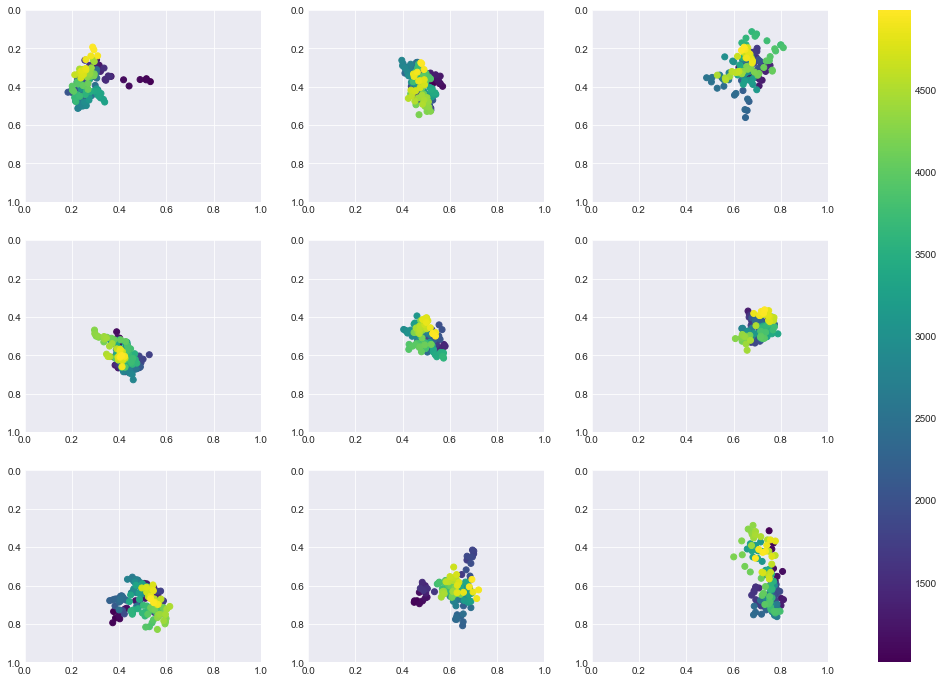

In [30]:
data_plot = data_et_fix.merge(data_trial_fix_raw.loc[:, ['run_id', 'trial_index', 'chin']], 
                             on=['run_id', 'trial_index'], 
                             how='left')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]

for i in range(0, 9):
    axes_data = data_plot.loc[
        (data_plot['run_id']==43) & 
        (data_plot['chin']==0) &
        (data_plot['x_pos']==xPos[i]) & 
        (data_plot['y_pos']==yPos[i]), 
        :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

# fps

## fps across subjects and trials

(array([3., 1., 2., 0., 5., 1., 5., 8., 3., 6., 1., 2., 0., 2., 1.]),
 array([ 0.31503366,  2.58227958,  4.84952551,  7.11677143,  9.38401735,
        11.65126328, 13.9185092 , 16.18575512, 18.45300104, 20.72024697,
        22.98749289, 25.25473881, 27.52198474, 29.78923066, 32.05647658,
        34.32372251]),
 <a list of 15 Patch objects>)

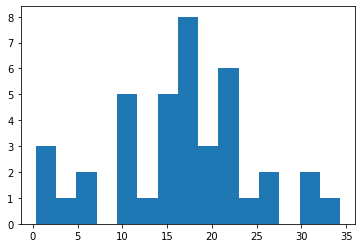

In [26]:
plt.hist(data_subject['fps'], bins=15)

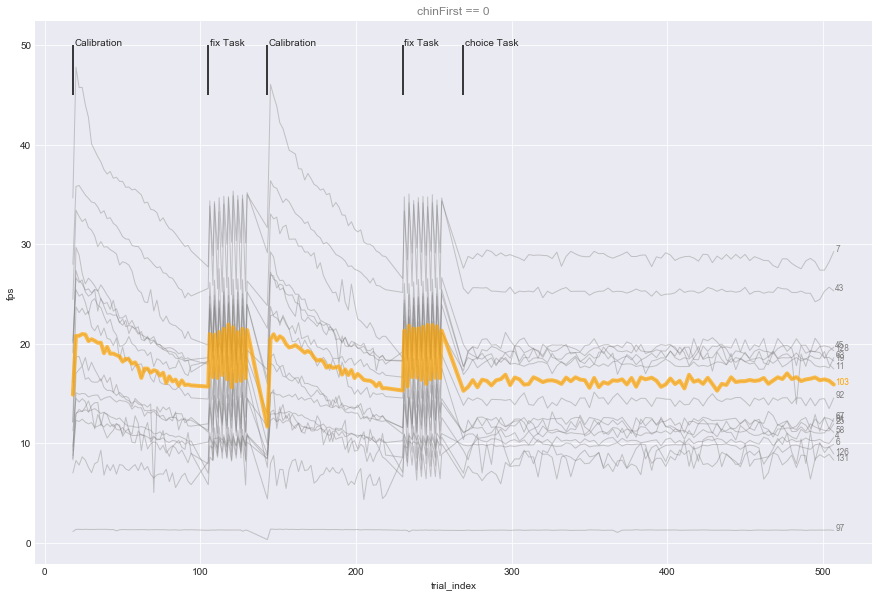

In [27]:
def spaghettiPlot(data, xVar, yVar):
    highlightedSubject = data['run_id'].unique()[0]
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw Plots
    for subject in data["run_id"].unique():
        df_thisSubject = data[data['run_id']==subject]
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_fixCal.loc[data_trial_fixCal['chinFirst']==0, :],     
    'trial_index', 
    'fps')
plt.title('chinFirst == 0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')
plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(143, 45, 50, colors='k', linestyles='solid')
plt.text(143+1, 50, s='Calibration')
plt.vlines(230, 45, 50, colors='k', linestyles='solid')
plt.text(230+1, 50, s='fix Task')
plt.vlines(269, 45, 50, colors='k', linestyles='solid')
plt.text(269+1, 50, s='choice Task')
plt.show()

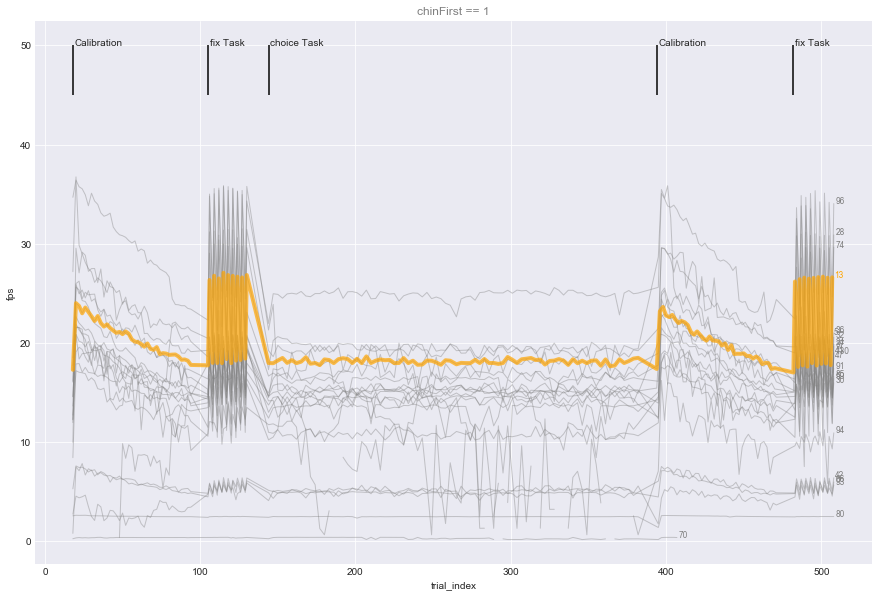

In [28]:
spaghettiPlot(
    data_trial_fixCal.loc[data_trial_fixCal['chinFirst']==1, :],     
    'trial_index', 
    'fps')
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('fps')

plt.vlines(18, 45, 50, colors='k', linestyles='solid')
plt.text(18+1, 50, s='Calibration')
plt.vlines(105, 45, 50, colors='k', linestyles='solid')
plt.text(105+1, 50, s='fix Task')
plt.vlines(144, 45, 50, colors='k', linestyles='solid')
plt.text(144+1, 50, s='choice Task')
plt.vlines(394, 45, 50, colors='k', linestyles='solid')
plt.text(394+1, 50, s='Calibration')
plt.vlines(482, 45, 50, colors='k', linestyles='solid')
plt.text(482+1, 50, s='fix Task')

plt.show()

# Data quality 

## Chin-rest conditions

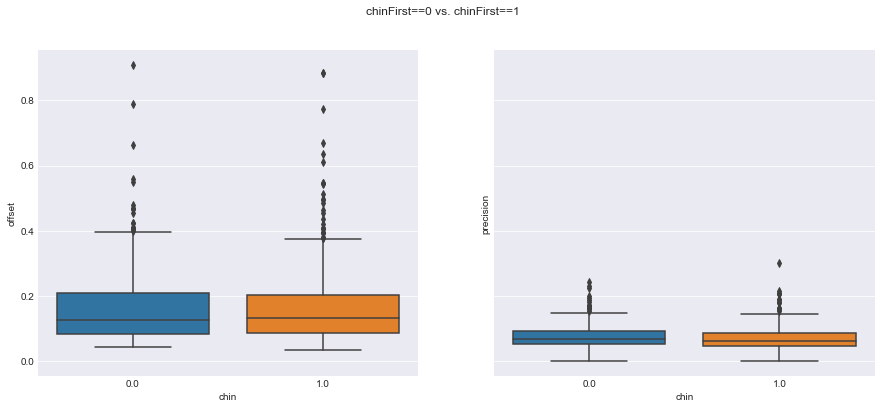

In [31]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

In [ ]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

In [ ]:
scipy.stats.ttest_rel(data_subject['offset_chin_0'], data_subject['offset_chin_1'])

### ChinFirst

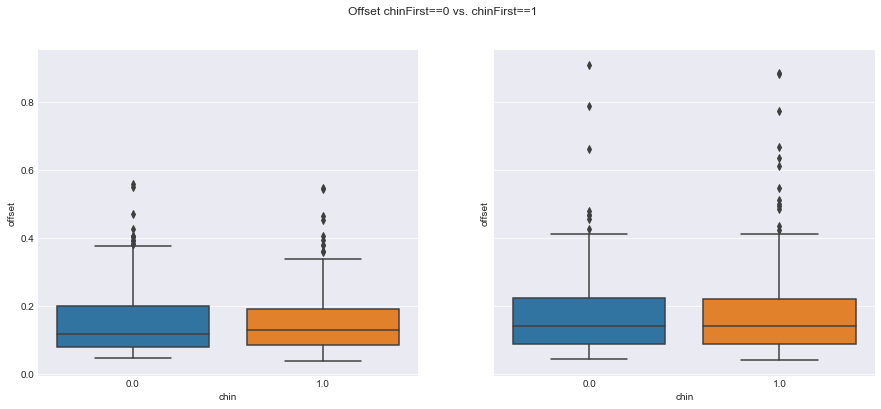

In [33]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

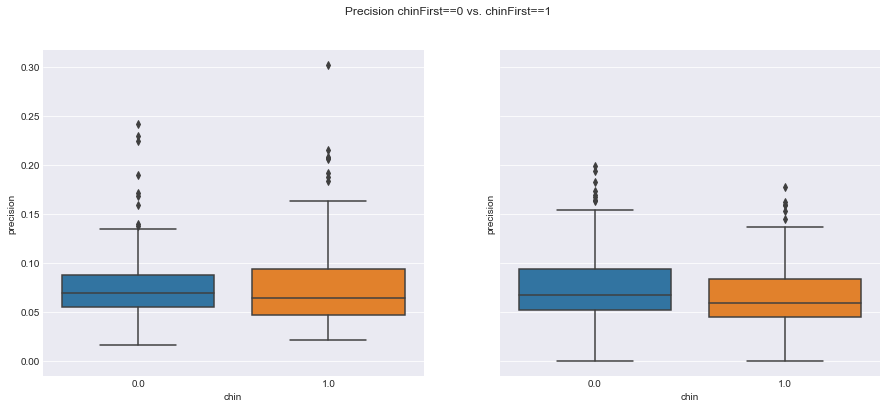

In [32]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

### Fixation dot positions

In [45]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.165476
offset_chin_1           0.172005
offset_var_chin_0       0.013481
offset_var_chin_1       0.016828
precision_chin_0        0.077216
precision_chin_1        0.071582
precision_var_chin_0    0.001204
precision_var_chin_1    0.001403
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.185200,0.178281,0.012992,0.010475,0.087751,0.075977,0.001827,0.001235
1,1,0.154817,0.174109,0.007832,0.017042,0.071629,0.073569,0.000705,0.001760
2,2,0.188193,0.207273,0.014363,0.018754,0.083105,0.071156,0.001990,0.001291
3,3,0.167982,0.169801,0.010763,0.011561,0.075945,0.074641,0.000941,0.001271
4,4,0.134428,0.142032,0.011242,0.015581,0.069093,0.063186,0.001371,0.001007
5,5,0.152300,0.163017,0.024465,0.025072,0.064675,0.065994,0.000635,0.001727
6,6,0.203890,0.177012,0.021448,0.018997,0.088647,0.080380,0.001346,0.001281
7,7,0.137490,0.168753,0.007843,0.021414,0.077883,0.068087,0.001137,0.000976
8,8,0.164983,0.167766,0.010381,0.012555,0.076216,0.071245,0.000881,0.002080


## Offset within trials, including fixation cross

In [ ]:
data_plot = data_et_fixCal.merge(
    data_trial_fixCal.loc[:, ['run_id', 'trial_index', 'task_nr', 'chinFirst', 'trial_duration', 'chin']],
    on=['run_id', 'trial_index'], 
    how='left'
)

data_plot = data_plot.loc[
    (data_plot['trial_type']=='eyetracking-fix-object') & 
    (
        (data_plot['task_nr']==1) |
        (
            (data_plot['chinFirst']==0) &
            (data_plot['task_nr']==2)
        ) |
        (
            (data_plot['chinFirst']==1) &
            (data_plot['task_nr']==3)
        )
    ), :].reset_index(drop=True)

data_plot.loc[
    (data_plot['trial_type']=='eyetracking-fix-object') &
    (data_plot['trial_duration']==1500), 
    't_task'] = data_plot.loc[
    (data_plot['trial_type']=='eyetracking-fix-object') &
    (data_plot['trial_duration']==1500), 
    't_task'] - 1500

data_trial_plot = data_trial_fixCal.loc[
    (data_trial_fixCal['trial_type']=='eyetracking-fix-object') & 
    (
        (data_trial_fixCal['task_nr']==1) |
        ((data_trial_fixCal['chinFirst']==0) & (data_trial_fixCal['task_nr']==2)) |
        ((data_trial_fixCal['chinFirst']==1) & (data_trial_fixCal['task_nr']==3))
    ), ['run_id', 'trial_index', 'trial_duration', 'x_pos', 'y_pos']].reset_index(drop=True)

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)
data_trial_plot = add_next_xy_pos(data_trial_plot)

data_plot = data_plot.merge(
    data_trial_plot.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

data_plot.loc[data_plot['trial_duration']==1500, 'offset'] = euclideanDistance(
    data_plot.loc[data_plot['trial_duration']==1500, 'x'], 
    data_plot.loc[data_plot['trial_duration']==1500, 'next_x_pos'], 
    data_plot.loc[data_plot['trial_duration']==1500, 'y'], 
    data_plot.loc[data_plot['trial_duration']==1500, 'next_y_pos']
)

In [213]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_plot.loc[data_plot['chin']==0, :])
average_line_chin = createAVGLine(data_plot.loc[data_plot['chin']==1, :])

Text(0.5, 0, 't_task')

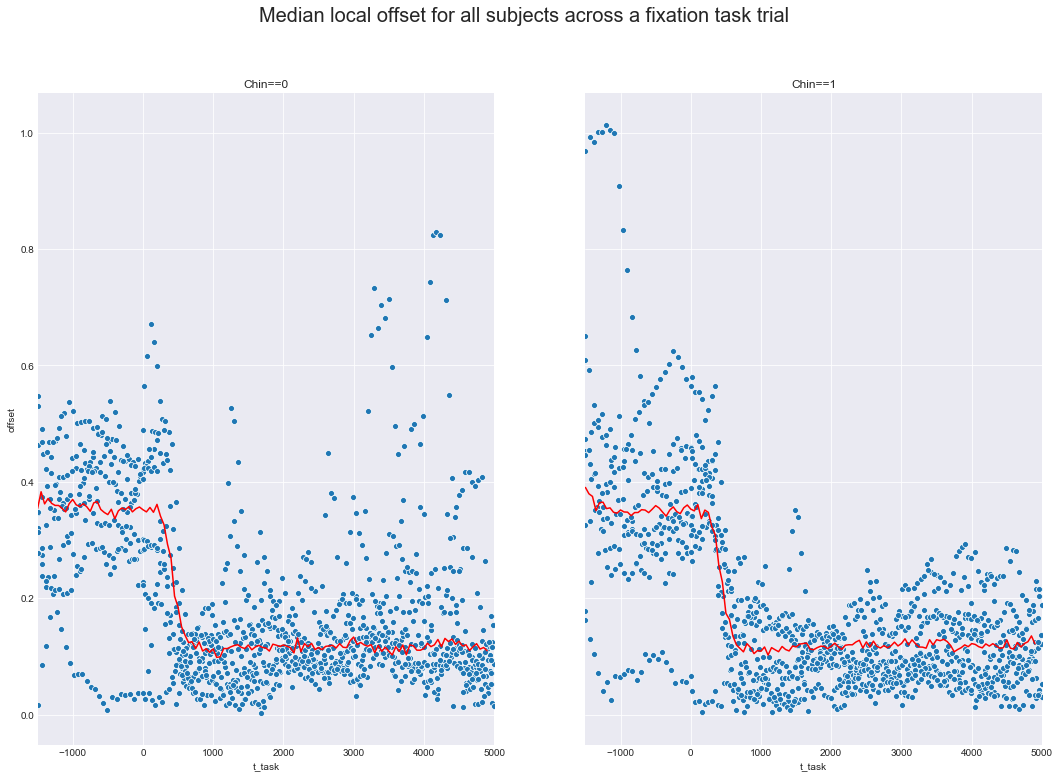

In [215]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")


sns.scatterplot(ax=axes[0], 
                data=data_plot.loc[(data_plot['run_id']==103) & (data_plot['chin']==0), :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_plot.loc[(data_plot['run_id']==103) & (data_plot['chin']==1), :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

# Calibration

## offset

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_fixCal['chin']==0, :], 
    'withinTaskIndex', 
    'offset'
)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_fixCal['chin']==1, :], 
    'withinTaskIndex', 
    'offset'
)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Precision

In [ ]:
spaghettiPlot(
    data_trial_fixCal.loc[
        (data_trial_fixCal['trial_type']=='eyetracking-calibration') &
        (data_trial_fixCal['chin']==0),
         :
    ], 
    'withinTaskIndex', 
    'precision_mean'
)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

In [ ]:
spaghettiPlot(
    data_trial_fixCal.loc[
        (data_trial_fixCal['trial_type']=='eyetracking-calibration') &
        (data_trial_fixCal['chin']==1),
         :
    ], 
    'withinTaskIndex', 
    'precision_mean'
)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

In [ ]:
spaghettiPlot(
    data_trial_fix.loc[
        (data_trial_fix['chinFirst']==1) &
        (data_trial_fix['chin']==0), 
        :],     
    'withinTaskIndex', 
    'offset_mean')
plt.title('chinFirst == 1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('trial_index')
plt.ylabel('offset_mean')

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fixation.loc[data_trial_fixation['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fixation.loc[data_trial_fixation['chinFirst']==1, :])
   
plt.show()

In [ ]:
data = data_trial_fixation.loc[data_trial_fixation['run_id'] == 0, :]
predictor = 'chin'
outcome = 'offset'
sample_A = data.loc[data[predictor] == 0, ['trial_index', 'offset']] \
    .drop_duplicates() \
    .reset_index(drop=True)

View(sample_A)

# Feedback

In [ ]:
print('Success! Script ran through')

# Archive

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(15,6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
                'gender',
                'ethnic', 
                'degree',
                'chinFirst', 
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='choseLL', data=data_subject)
   
plt.show()

In [ ]:
# window_diagonal_max
# age
# choiceNr
def bubblePlot(categorical_variable, distinct_variable, data):
    
    sns.set_context("talk", font_scale=1.1)
    plt.figure(figsize=(5,6))
    
    data_bubblePlot = data.loc[:, [categorical_variable, distinct_variable]]
    grouped = data_bubblePlot.groupby([distinct_variable]) \
        .count() \
        .rename(columns={categorical_variable: 'n'}) \
        .reset_index()
    data_bubblePlot = data_bubblePlot.merge(grouped, 
                                                 on=distinct_variable, 
                                                 how='left')
    data_bubblePlot['n'] = data_bubblePlot['n']     
    
    sns.scatterplot(x=categorical_variable, 
                    y=distinct_variable,
                    size='n',            
                    data=data_bubblePlot)
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.xlabel(categorical_variable)
    plt.xticks([0, 1])
    plt.ylabel(distinct_variable)
    plt.tight_layout()
    plt.show()

bubblePlot(categorical_variable = 'choseLL', 
           distinct_variable = 'age', 
           data = data_trial_choice)

In [ ]:
correlation_columns = [
                            'trial_duration_exact',
                            'fps',
                            'k', 
                            'choiceNr',
                            'optionIndex',
                            'attributeIndex', 
                            'payneIndex',
                        ]

In [ ]:
sns.pairplot(data_trial_choice_clean.loc[:,
        np.append(correlation_columns, ['LL_top'])
    ],
    hue='LL_top')

In [ ]:
sns.pairplot(data_trial_choice_clean.loc[:,
        np.append(correlation_columns, ['choseTop'])
    ],
    hue='choseTop')

In [ ]:
corr_matrix = np.corrcoef(data_trial_choice_clean[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [ ]:
data_trial_choice_clean[correlation_columns].rcorr()

In [ ]:
data_trial_choice_clean[correlation_columns].rcorr(upper='n')